In [1]:
# To default to float division and print function.
from __future__ import (division, print_function)

# Core python libraries
import csv
import re
import math

# External libraries.
import nltk
import numpy
import pandas
import scipy
import sklearn

# Tensorflow and related.
import tensorflow

# For fitting streamlined tensor flow models.
import tflearn

# So you know when this code block finishes.
print ("Done")

hdf5 not supported (please install/reinstall h5py)
Done


In [47]:
#TODO (max): make a library that does all this preprocessing
data = pandas.read_csv('data/train.csv', nrows=5000) #Can read a subset. First nrows of the total.
LABEL_COLUMN = "LogSalaryNormalized"

binomial = False

if binomial:
    # This is for use in exploring logistic regression. Need a binomial outcome variable
    LABEL_COLUMN = "HighPayingJobs"
    data[LABEL_COLUMN] = (data["SalaryNormalized"].apply(lambda x: x >= 30000)).astype(int)

print(len(data))

5000


In [48]:
X_train_index, X_test_index, Y_train, Y_test = sklearn.cross_validation.train_test_split(
    data.index, data['LogSalaryNormalized'], test_size=.33, random_state=42)

# Keep train and test as pandas dataframes.
X_train = data.iloc[X_train_index]
X_test = data.iloc[X_test_index]

yb_train = X_train[LABEL_COLUMN]
yb_test= X_test[LABEL_COLUMN]

# Uncomment this next line if you want to check the data.
#print(data.head())

print ("Done")

Done


In [6]:
MIN_WORD_FREQUENCY = 3

count_vect = sklearn.feature_extraction.text.CountVectorizer(
  stop_words='english', min_df=MIN_WORD_FREQUENCY)

# Here I am count vectoring the full description field. But in theory
# any text field can be processed this way.
X_train_full_description_counts = count_vect.fit_transform(X_train['FullDescriptionWithTitle'])
X_test_full_description_counts = count_vect.transform(X_test['FullDescriptionWithTitle'])

print(X_train_full_description_counts.shape)
print(X_test_full_description_counts.shape)
#TODO (max): supress the VisibleDeprecationWarning here from numpy. It is being thrown by the package.

(3350, 7166)
(1650, 7166)


In [7]:
def mean_absolute_error_salary_scale(y_test, y_predicted):
    return sklearn.metrics.mean_absolute_error(
        numpy.exp(y_test), numpy.exp(y_predicted))

# Guess the average. Create an empty vector of the desired shape.
average_guess = numpy.empty(Y_test.shape)
average_guess.fill(numpy.mean(Y_train))

mean_guess = average_guess[0]
print('Mean salary value in training set is  £{:10.2f}'.format(math.exp(mean_guess)))
average_guess_mae = mean_absolute_error_salary_scale(Y_test, average_guess)
print('Guess the average Mean Absolute Error: {:10.4f}'.format(average_guess_mae))

# SGD Needs normalized inputs
normalizer = sklearn.preprocessing.Normalizer(norm='l1')
X_train_norm = normalizer.fit_transform(X_train_full_description_counts.astype('float64'))
X_test_norm = normalizer.transform(X_test_full_description_counts.astype('float64'))

# We want a stochastic gradient descent with l1 norm.
sgd = sklearn.linear_model.SGDRegressor(alpha=.005, penalty='l1', n_iter=100)
sgd.fit(X_train_norm, Y_train)
sgd_predictions = sgd.predict(X_test_norm)
sgd_mae = mean_absolute_error_salary_scale(Y_test, sgd_predictions)
print('SGDRegressor Mean Absolute Error: {:10.4f}'.format(sgd_mae))
#TODO (any): wonder why this is so inaccurate/wrong

Mean salary value in training set is  £  27669.95
Guess the average Mean Absolute Error: 10490.1392
SGDRegressor Mean Absolute Error: 22185.5734


In [91]:
# feature_cols: A dict from feature column names to Tensors or SparseTensors.
# label: A Tensor containing the label column

# The keys of the feature_cols will be used to when construct columns in the next
# section. Because we want to call the fit and evaluate methods with different 
# data, we define two different input builder functions, train_input_fn and
# test_input_fn which are identical except that they pass different data to
# input_fn. Note that input_fn will be called while constructing the TensorFlow
# graph, not while running the graph. What it is returning is a representation
# of the input data as the fundamental unit of TensorFlow computations, a Tensor
# (or SparseTensor).

CONTINUOUS_COLUMNS = ["LogSalaryNormalized", "DescriptionLength"]

CATEGORICAL_COLUMNS = ["ContractTime", "ContractType"]

def input_fn(df):
  # Creates a dictionary mapping from each continuous feature column name (k) to
  # the values of that column stored in a constant Tensor.
  continuous_cols = {k: tensorflow.constant(df[k].values)
                     for k in CONTINUOUS_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tensorflow.SparseTensor.
  categorical_cols = {k: tensorflow.SparseTensor(
      indices=[[i, 0] for i in range(df[k].size)],
      values=df[k].values,
      shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(continuous_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tensorflow.constant(df[LABEL_COLUMN].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(X_train)

def eval_input_fn():
  return input_fn(X_test)


import tempfile

# This is a test. It should give 100% accuracy. Something is amiss.
salary_normalized = tensorflow.contrib.layers.real_valued_column(
    "LogSalaryNormalized")
# Real features.
description_length = tensorflow.contrib.layers.real_valued_column(
    "DescriptionLength")

contract_time = tensorflow.contrib.layers.sparse_column_with_hash_bucket(
    "ContractTime", hash_bucket_size=100)
contract_type = tensorflow.contrib.layers.sparse_column_with_hash_bucket(
    "ContractType", hash_bucket_size=100)

FEATURE_COLUMNS = [
        # salary_normalized,
        description_length, contract_time, contract_type
    ]

model_dir = tempfile.mkdtemp()
m = tensorflow.contrib.learn.LinearRegressor(feature_columns=FEATURE_COLUMNS,
    #"""optimizer=tensorflow.train.FtrlOptimizer(
    #learning_rate=0.1,
    #l1_regularization_strength=1.0,
    #l2_regularization_strength=1.0)"""
  model_dir=model_dir)

In [100]:
m.fit(input_fn=train_input_fn, steps=3000)


LinearRegressor()

In [101]:
results = m.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print ("%s: %s" % (key, results[key]))

loss: 0.297318


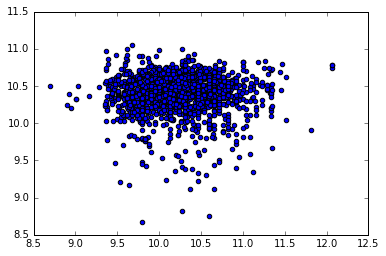

1501   -0.331539
2586   -0.189387
2653   -0.947171
1055    0.148050
705    -0.544096
106     0.470289
589    -0.658666
2468    1.210997
2413   -0.211858
1600    0.591787
2464    0.004721
228    -0.305507
915    -0.135452
794    -0.156998
3021   -0.437716
...
1237    0.059701
103    -0.380451
2643    0.055527
272     0.483545
508     0.275529
2226    0.284970
4933    0.093357
2441    0.340052
865    -0.053492
3326   -0.048866
908    -0.327740
2114    0.356737
3896    0.324646
1627    0.085365
2873    0.232752
Name: LogSalaryNormalized, Length: 1650, dtype: float64
13507.5854859


In [102]:
%matplotlib inline

import matplotlib.pyplot as plt

x, y = eval_input_fn()

# There is the old issue :D All 0 values :(
y_vals = m.predict(input_fn=eval_input_fn)
x_vals = X_test[LABEL_COLUMN]


plt.scatter(x_vals, y_vals)
plt.show()

print(x_vals-y_vals)

print(mean_absolute_error_salary_scale(y_vals, x_vals))

In [109]:
d =  tensorflow.contrib.learn.DNNRegressor(
    feature_columns=[description_length],
    hidden_units=[64, 32, 8])

In [110]:
d.fit(input_fn=train_input_fn, steps=1000)


DNNRegressor()

In [111]:
results = d.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print ("%s: %s" % (key, results[key]))

loss: 11.8243


In [ ]:
# deep_columns = [
#  tf.contrib.layers.embedding_column(workclass, dimension=8),
#]

# Continue on from https://www.tensorflow.org/versions/r0.10/tutorials/wide_and_deep/index.html